<a href="https://colab.research.google.com/github/spatank/GraphRL/blob/main/multiple_environments_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/GraphRL/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
#@title Imports

import networkx as nx
from functools import lru_cache
import random
import numpy as np
import time
from copy import deepcopy
import time
from typing import NamedTuple
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams["animation.html"] = "jshtml"

import torch # check version using torch.__version__ before using PyG wheels
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import sys
!{sys.executable} -m pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!{sys.executable} -m pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!{sys.executable} -m pip install -q torch-geometric

import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric import utils, transforms

!{sys.executable} -m pip install -q Cython
!{sys.executable} -m pip install -q Ripser

from ripser import ripser

In [89]:
#@title Environments

@lru_cache(maxsize = 100000)
def get_NX_subgraph(environment, frozen_set_of_nodes):

  return environment.graph_NX.subgraph(list(frozen_set_of_nodes))

@lru_cache(maxsize = 500000)
def get_PyG_subgraph(environment, frozen_set_of_nodes):

  return environment.graph_PyG.subgraph(torch.tensor(list(frozen_set_of_nodes)))

@lru_cache(maxsize = 100000)
def compute_feature_value(environment, state_subgraph_NX):

  return environment.feature_function(state_subgraph_NX)

@lru_cache(maxsize = 100000)
def get_neighbors(environment, frozen_set_of_nodes, cutoff = 1):
  """
  Returns the n-th degree neighborhood of a set of nodes, where degree 
  is specified by the cutoff argument.
  """

  nodes = list(frozen_set_of_nodes)
  neighbors = set()

  for node in nodes:
    neighbors.update(set(nx.single_source_shortest_path_length(environment.graph_NX, 
                                                               node, 
                                                               cutoff = cutoff).keys()))
    
  neighbors = neighbors - set(nodes) # remove input nodes from their own neighborhood

  if not neighbors:
    neighbors = set(environment.graph_NX.nodes()) - set(environment.visited)

  return list(neighbors)

class GraphEnvironment():
  
  def __init__(self, ID, graph_NX, feature):
    super().__init__()

    self.ID = ID # identifier for the environment

    self.graph_NX = graph_NX # environment graph (NetworkX Graph object)  
    self.graph_PyG = utils.from_networkx(graph_NX, group_node_attrs = all)
    self.num_nodes = self.graph_NX.number_of_nodes()

    self.visited = [random.choice(list(self.graph_NX.nodes()))] # list of visited nodes

    self.state_NX = get_NX_subgraph(self, frozenset(self.visited))
    self.state_PyG = get_PyG_subgraph(self, frozenset(self.visited))

    self.feature_function = feature # function handle to network feature-of-interest
    self.feature_values = [self.feature_function(self.state_NX)] # list to store values of the feature-of-interest
    
  def step(self, action):
    """
    Execute an action in the environment, i.e. visit a new node.
    """

    assert action in self.get_actions(self.visited), "Invalid action!"
    visited_new = deepcopy(self.visited)
    visited_new.append(action) # add new node to list of visited nodes
    self.visited = visited_new
    self.state_NX = get_NX_subgraph(self, frozenset(self.visited))
    self.state_PyG = get_PyG_subgraph(self, frozenset(self.visited))
    reward = self.compute_reward()
    terminal = bool(len(self.visited) == self.graph_NX.number_of_nodes())

    return self.get_state_dict(), reward, terminal, self.get_info()

  def compute_reward(self):

    self.feature_values.append(compute_feature_value(self, self.state_NX))
    reward = sum(self.feature_values)/len(self.visited)

    return reward

  def reset(self):
    """
    Reset to initial state.
    """

    self.visited = [random.choice(list(self.graph_NX.nodes()))] # empty the list of visited nodes
    self.state_NX = get_NX_subgraph(self, frozenset(self.visited))
    self.state_PyG = get_PyG_subgraph(self, frozenset(self.visited))
    self.feature_values = [compute_feature_value(self, self.state_NX)]
    terminal = False

    return self.get_state_dict(), terminal, self.get_info()

  def get_state_dict(self):

    return {'visited': self.visited, 
            'state_NX': self.state_NX, 
            'state_PyG': self.state_PyG}
      
  def get_info(self):
    
    return {'environment_ID': self.ID, # useful for DQN training
            'feature_value': compute_feature_value(self, self.state_NX)}
  
  def get_actions(self, nodes):
    """ 
    Returns available actions given a list of nodes.
    """

    return get_neighbors(self, frozenset(nodes))
  
  def render(self):
    """
    Render current state to the screen.
    """

    plt.figure()
    nx.draw(self.state_NX, with_labels = True)

class MultipleEnvironments():

  def __init__(self, environments):
    
    self.environments = environments
    self.num_environments = len(self.environments)

  def reset(self):

    state_dicts = []
    terminals = []
    all_info = []

    for environment in self.environments:
      state_dict, terminal, info = environment.reset()
      state_dicts.append(state_dict)
      terminals.append(terminal)
      all_info.append(info)

    return state_dicts, terminals, all_info
  
  def step(self, actions):

    state_dicts = []
    rewards = []
    terminals = []
    all_info = []

    for idx, environment in enumerate(self.environments):
      state_dict, reward, terminal, info = environment.step(actions[idx])
      state_dicts.append(state_dict)
      rewards.append(reward)
      terminals.append(terminal)
      all_info.append(info)

    return state_dicts, rewards, terminals, all_info

In [90]:
#@title Baseline Agents

class RandomAgent():
  """RandomAgent() chooses an action at random. The agent is not deterministic."""
  
  def __init__(self):
    super().__init__()
    
    self.environments = None # should be instance of MultipleEnvironments() class
    self.is_trainable = False # useful to manage control flow during simulations

  def choose_action(self):

    if not self.environments:
      assert False, "Supply environment(s) for the agent to interact with."

    actions = []

    for environment in self.environments.environments:
      available_actions = environment.get_actions(environment.visited)
      action = random.choice(available_actions)
      actions.append(action)

    return actions

class HighestDegreeAgent():
  """HighestDegreeAgent() chooses the action with the highest node degree. The 
  agent is deterministic."""

  def __init__(self):
    super().__init__()

    self.environments = None # should be instance of MultipleEnvironments() class
    self.is_trainable = False # useful to manage control flow during simulations

  def choose_action(self):

    if not self.environments:
      assert False, "Supply environment(s) for the agent to interact with."

    actions = []

    for environment in self.environments.environments:
      available_actions = environment.get_actions(environment.visited)
      all_degrees = list(zip(*(environment.graph_NX.degree(available_actions))))[1]
      action_idx = all_degrees.index(max(all_degrees)) # first largest when ties
      action = available_actions[action_idx]
      actions.append(action)

    return actions

class GreedyAgent():
  """GreedyAgent() chooses the action that would result in the greatest reward.
  The agent uses a copy of the environment to simulate each available action and 
  returns the best performing action. The agent is deterministic."""

  def __init__(self):
    super().__init__()

    self.environments = None # should be instance of MultipleEnvironments() class
    self.is_trainable = False # useful to manage control flow during simulations

  def choose_action(self):

    if not self.environments:
      assert False, "Supply environment(s) for the agent to interact with."

    actions = []

    for environment in self.environments.environments:
      available_actions = environment.get_actions(environment.visited)
      best_reward = float('-inf')
      best_action = None

      for action in available_actions:
        environment_copy = deepcopy(environment)
        state_dict, reward, terminal, info = environment_copy.step(action)

        if reward > best_reward:
          best_reward = reward
          best_action = action

      actions.append(best_action)

    return actions

In [91]:
#@title DQN Agent

class GNN(nn.Module):

  def __init__(self, hyperparameters):
    super().__init__()
    
    self.conv1 = SAGEConv(
        hyperparameters['num_node_features'],
        hyperparameters['GNN_latent_dimensions'],
        aggr = 'mean')
    self.conv2 = SAGEConv(
        hyperparameters['GNN_latent_dimensions'],
        hyperparameters['embedding_dimensions'],
        aggr = 'mean')

  def forward(self, x, edge_index, batch = None):

    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x) # node embeddings
    x = torch_geometric.nn.global_add_pool(x, batch = batch) # graph embedding

    return x

class QN(nn.Module):

  def __init__(self, hyperparameters):
    super().__init__()

    self.fc1 = nn.Linear(hyperparameters['embedding_dimensions'], 
                         hyperparameters['QN_latent_dimensions'])
    self.fc2 = nn.Linear(hyperparameters['QN_latent_dimensions'], 1)

  def forward(self, x):

    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x

class DQNAgent():

  def __init__(self, embedding_module, q_net, 
               replay_buffer, train_start, batch_size, learn_every,
               optimizer, 
               epsilon, epsilon_decay_rate, epsilon_min):
    super().__init__()

    self.environments = None # should be instance of MultipleEnvironments() class
    self.is_trainable = True # useful to manage control flow during simulations

    self.embedding_module = embedding_module
    self.q_net = q_net

    self.target_embedding_module = deepcopy(embedding_module)
    self.target_q_net = deepcopy(q_net)
    
    # disable gradients for target networks
    for parameter in self.target_embedding_module.parameters():
      parameter.requires_grad = False

    for parameter in self.target_q_net.parameters():
      parameter.requires_grad = False
    
    self.replay_buffer = replay_buffer
    self.train_start = train_start # specify burn-in period
    self.batch_size = batch_size
    self.learn_every = learn_every # steps between updates to target nets

    self.optimizer = optimizer

    self.epsilon = epsilon # probability with which to select a non-greedy action
    self.epsilon_decay_rate = epsilon_decay_rate
    self.epsilon_min = epsilon_min

    self.step = 0

  def choose_action(self):
    """
    Choose an action to perform for each environment in self.environments.
    """

    if not self.environments:
      assert False, "Supply environment(s) for the agent to interact with."

    actions = []

    for environment in self.environments.environments:
      available_actions = environment.get_actions(environment.visited)
      new_subgraphs = [] # list to store all possible next states

      for action in available_actions:
        visited_nodes_new = deepcopy(environment.visited)
        visited_nodes_new.append(action)
        new_subgraph = get_PyG_subgraph(environment, frozenset(visited_nodes_new))
        new_subgraphs.append(new_subgraph)

      # create a batch to allow for a single forward pass
      batch = Batch.from_data_list(new_subgraphs)

      # gradients for the target networks are disabled
      with torch.no_grad(): # technically redundant
        q_values = self.target_q_net(self.target_embedding_module(batch.x, 
                                                                  batch.edge_index, 
                                                                  batch.batch))
      if torch.rand(1) < self.epsilon: # explore
        action = np.random.choice(available_actions)
      else: # exploit
        action_idx = torch.argmax(q_values).item()
        action = available_actions[action_idx]

      actions.append(action)

    return actions

  def train(self, state_dicts, actions, next_state_dicts, rewards, discounts, all_info):

    self.replay_buffer.add(state_dicts, actions, next_state_dicts, rewards, discounts, all_info)
    self.step += 1
    
    if self.step < self.train_start: # inside the burn-in period
      return 

    # (1) Get lists of experiences from memory
    states, actions, next_states, rewards, discounts, all_info = self.replay_buffer.sample(self.batch_size)
    
    # (2) Build state + action = new subgraph (technically identical to next state)
    new_subgraphs = []
    for idx, state_dict in enumerate(states):
      visited_nodes_new = deepcopy(state_dict['visited'])
      visited_nodes_new.append(actions[idx])
      assert visited_nodes_new == next_states[idx]['visited'], "train() assertion failed."
      new_subgraph = get_PyG_subgraph(self.environments.environments[all_info[idx]['environment_ID']], 
                                      frozenset(visited_nodes_new))
      new_subgraphs.append(new_subgraph)

    batch = Batch.from_data_list(new_subgraphs)

    # (3) Pass batch of next_state subgraphs through ANN to get predicted q-values
    q_predictions = self.q_net(self.embedding_module(batch.x, 
                                                     batch.edge_index, 
                                                     batch.batch))

    # (4) Compute target q-values for batch
    q_targets = []
    for idx, next_state_dict in enumerate(next_states):
      available_actions = self.environments.environments[all_info[idx]['environment_ID']].get_actions(next_state_dict['visited'])

      if available_actions: # terminal states have no available actions
        new_subgraphs = [] # each available action results in a new state

        for action in available_actions:
          visited_nodes_new = deepcopy(next_state_dict['visited'])
          visited_nodes_new.append(action)
          new_subgraph = get_PyG_subgraph(self.environments.environments[all_info[idx]['environment_ID']], 
                                          frozenset(visited_nodes_new))
          new_subgraphs.append(new_subgraph)

        batch = Batch.from_data_list(new_subgraphs)

        with torch.no_grad(): # technically, no_grad() is unnecessary
          q_target = self.target_q_net(self.target_embedding_module(batch.x, 
                                                                    batch.edge_index, 
                                                                    batch.batch))
          q_target = q_target.max().view(-1, 1) # get the largest next q-value
          q_target = rewards[idx] + discounts[idx] * q_target
          q_targets.append(q_target)

      else:
        q_targets.append(rewards[idx])

    q_targets = torch.Tensor(q_targets).view(-1, 1)
      
    # (5) Compute MSE loss between predicted and target q-values
    loss = F.mse_loss(q_predictions, q_targets).mean()

    # (6) Backpropagate gradients
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # (7) Copy parameters from source to target networks
    if self.step % self.learn_every == 0: 
      copy_parameters_from_to(self.embedding_module, self.target_embedding_module)
      copy_parameters_from_to(self.q_net, self.target_q_net)
      
    # (8) Decrease exploration rate
    self.epsilon *= self.epsilon_decay_rate
    self.epsilon = max(self.epsilon, self.epsilon_min)

    return loss.item() # for logging

In [92]:
#@title Helper Functions: Miscellaneous

def compute_Frobenius_norm(network):
    """
    Compute the Frobenius norm of all network tensors.
    """
    norm = 0.0

    for name, param in network.named_parameters():
        norm += torch.norm(param).data  
               
    return norm.item()

def copy_parameters_from_to(source_network, target_network):
  """
  Update the parameters of the target network by copying values from the source
  network.
  """

  for source, target in zip(source_network.parameters(), target_network.parameters()):
    target.data.copy_(source.data)

  return

def average_area_under_the_curve(all_feature_values):
  """
  Returns the average area under the curve given a list of list of feature 
  values. Each list inside all_feature_values corresponds to an environment. 
  Each list inside that list corresponds to an episode. Each element of the 
  inner list is a feature value at a given step during an episode.
  """

  all_areas = []
  for env_results in all_feature_values:
    areas = [sum(feature_values) for feature_values in env_results]
    all_areas.append(sum(areas)/len(areas))
  
  return sum(all_areas)/len(all_areas)

class ReplayBuffer():
  
  def __init__(self, buffer_size):

    self.buffer_size = buffer_size
    self.ptr = 0 # index to latest experience in memory
    self.num_experiences = 0 # number of experiences stored in memory
    self.states = [None] * self.buffer_size
    self.actions = [None] * self.buffer_size
    self.next_states = [None] * self.buffer_size
    self.rewards = [None] * self.buffer_size
    self.discounts = [None] * self.buffer_size
    self.all_info = [None] * self.buffer_size

  def add(self, state_dicts, actions, next_state_dicts, rewards, discounts, all_info):

    # check if arguments are lists
    if not isinstance(state_dicts, list): # i.e. a single experience
      state_dicts = [state_dicts]
      actions = [actions]
      next_state_dicts = [next_state_dicts]
      rewards = [rewards]
      discounts = [discounts]
      all_info = [all_info]

    for i in range(len(state_dicts)):
      self.states[self.ptr] = state_dicts[i]
      self.actions[self.ptr] = actions[i]
      self.next_states[self.ptr] = next_state_dicts[i]
      self.rewards[self.ptr] = rewards[i]
      self.discounts[self.ptr] = discounts[i]
      self.all_info[self.ptr] = all_info[i]
      
      if self.num_experiences < self.buffer_size:
        self.num_experiences += 1

      self.ptr = (self.ptr + 1) % self.buffer_size 
      # if (ptr + 1) exceeds buffer size then begin overwriting older experiences

  def sample(self, batch_size):      

    indices = np.random.choice(self.num_experiences, batch_size)   
    states = [self.states[index] for index in indices] 
    actions = [self.actions[index] for index in indices] 
    next_states = [self.next_states[index] for index in indices] 
    rewards = [self.rewards[index] for index in indices] 
    discounts = [self.discounts[index] for index in indices] 
    all_info = [self.all_info[index] for index in indices] 
    
    return states, actions, next_states, rewards, discounts, all_info

def generate_video(plotting_dict):

  feature_values_random = plotting_dict['random']
  feature_values_degree = plotting_dict['degree']
  feature_values_greedy = plotting_dict['greedy']
  feature_values_DQN = np.array(plotting_dict['DQN'])

  xlim = feature_values_DQN.shape[1]
  x = np.arange(xlim) # number of nodes

  ylim = max(max(feature_values_random), 
             max(feature_values_degree), 
             max(feature_values_greedy), 
             np.max(feature_values_DQN))

  fig, ax = plt.subplots()
  ax.axis([0, xlim, 0, ylim + 0.01 * ylim])

  line1, = ax.plot(x, feature_values_random, label = 'random', color = 'blue')
  line2, = ax.plot(x, feature_values_degree, label = 'max degree', color = 'orange')
  line3, = ax.plot(x, feature_values_greedy, label = 'greedy', color = 'green')
  line4, = ax.plot([], [], label = 'DQN', color = 'black')

  ax.legend()

  plt.xlabel('Step')
  plt.ylabel('Value')

  def animate(i):
    line4.set_data(x, feature_values_DQN[i])
    
  anim_handle = animation.FuncAnimation(fig, animate, 
                                        frames = len(feature_values_DQN),
                                        interval = 100,  
                                        blit = False, repeat = False, 
                                        repeat_delay = 10000)
  plt.close() # do not show extra figure

  return anim_handle

def node_featurizer(graph_NX):

  graph_NX = deepcopy(graph_NX)

  attributes = {}

  for node in graph_NX.nodes():
    neighborhood = set(nx.single_source_shortest_path_length(graph_NX, node, cutoff = 1).keys())
    neighborhood.remove(node) # remove node from its own neighborhood
    neighborhood = list(neighborhood) 

    if neighborhood:
      neighborhood_degrees = list(map(list, zip(*graph_NX.degree(neighborhood))))[1]
    else: # no neighbors
      neighborhood_degrees = [0]

    node_attributes = {}
    node_attributes['degree_1'] = graph_NX.degree(node)
    node_attributes['min_degree_1'] = min(neighborhood_degrees)
    node_attributes['max_degree_1'] = max(neighborhood_degrees)
    node_attributes['mean_degree_1'] = float(np.mean(neighborhood_degrees))
    node_attributes['std_degree_1'] = float(np.std(neighborhood_degrees))

    neighborhood = set(nx.single_source_shortest_path_length(graph_NX, node, cutoff = 2).keys())
    neighborhood.remove(node) # remove node from its own neighborhood
    neighborhood = list(neighborhood) 

    if neighborhood:
      neighborhood_degrees = list(map(list, zip(*graph_NX.degree(neighborhood))))[1]
    else: # no neighbors
      neighborhood_degrees = [0]

    node_attributes['min_degree_2'] = min(neighborhood_degrees)
    node_attributes['max_degree_2'] = max(neighborhood_degrees)
    node_attributes['mean_degree_2'] = float(np.mean(neighborhood_degrees))
    node_attributes['std_degree_2'] = float(np.std(neighborhood_degrees))

    attributes[node] = node_attributes
    
  nx.set_node_attributes(graph_NX, attributes)

  return graph_NX

def node_defeaturizer(graph_NX):

  graph_NX = deepcopy(graph_NX)

  for (n, d) in graph_NX.nodes(data = True):

    del d["degree_1"]
    del d["min_degree_1"]
    del d["max_degree_1"]
    del d["mean_degree_1"]
    del d["std_degree_1"]
    del d["min_degree_2"]
    del d["max_degree_2"]
    del d["mean_degree_2"]
    del d["std_degree_2"]

    return graph_NX

In [93]:
#@title Helper Functions: Simulation

def simulate(agent, environments, num_episodes = 100, verbose = True):
  """
  Simulate agent in multiple environments for a specified number of episodes.
  We do not use methods from the MultipleEnvironment() class because each 
  environment may have a different number of nodes.
  """

  agent = deepcopy(agent) # do not alter the supplied agent's environments
  agent.environments = environments # supply the agent with different environments

  all_feature_values = []

  for idx, environment in enumerate(tqdm(environments.environments, 
                                         disable = not verbose)):
    
    state_dict, terminal, info = environment.reset()
    environment_feature_values = []

    for _ in range(num_episodes):
      episode_rewards = []
      episode_feature_values = []
      
      while not terminal:
        actions = agent.choose_action() 
        action = actions[idx] # agent chooses an action for each environment
        state_dict, reward, terminal, info = environment.step(action)
        episode_feature_values.append(info['feature_value'])
      
      state_dict, terminal, info = environment.reset() # reset environment after use

      environment_feature_values.append(episode_feature_values)
      
    all_feature_values.append(environment_feature_values)
  
  return all_feature_values

def learn_environments(agent, train_environments, val_environments, 
                       num_steps, discount_factor = None, 
                       log_val_results = True, verbose = True):
  """
  Train agent on multiple environments by simulating agent-environment 
  interactions for a specified number of steps.
  """

  agent.environments = train_environments # supply the agent with environments

  all_episode_returns_train = [[] for i in range(train_environments.num_environments)]
  all_episode_feature_values_train = [[] for i in range(train_environments.num_environments)]

  episode_returns_train = [0] * train_environments.num_environments
  episode_feature_values_train = [[] for i in range(train_environments.num_environments)]

  if not val_environments: 
    log_val_results = False
  val_results = []
  val_score = -float('inf')

  state_dicts, terminals, all_info = train_environments.reset()

  pbar = tqdm(range(num_steps), unit = 'Step', disable = not verbose)

  for step in pbar:
    actions = agent.choose_action() # choose an action for each environment
    next_state_dicts, rewards, terminals, all_info = train_environments.step(actions)
    episode_returns_train = [sum(x) for x in zip(rewards, episode_returns_train)]

    for idx, info in enumerate(all_info):
      episode_feature_values_train[idx].append(info['feature_value'])

    if agent.is_trainable:
      discounts = [discount_factor * (1 - terminal) for terminal in terminals]
      loss = agent.train(state_dicts, actions, next_state_dicts, rewards, discounts, all_info)
      
      if log_val_results and step % 500 == 0 or step == num_steps:
        all_feature_values_val = simulate(agent, val_environments,
                                          num_episodes = 10, verbose = False)
        val_score = average_area_under_the_curve(all_feature_values_val)
        val_results.append(val_score)

      if loss: 
        pbar.set_description('Loss: %0.5f, Val. Score: %0.5f' % (loss, val_score))
      else: # no loss value is returned inside the burn-in period
        pbar.set_description('Loss: %0.5f, Val. Score: %0.5f' % (float('inf'), val_score))

    state_dicts = next_state_dicts

    for idx, terminal in enumerate(terminals):
      # if terminal then gather episode results for this environment and reset
      if terminal: 
        all_episode_returns_train[idx].append(episode_returns_train[idx])
        episode_returns_train[idx] = 0
        all_episode_feature_values_train[idx].append(episode_feature_values_train[idx])
        episode_feature_values_train[idx] = []
        state_dict, terminal, info = train_environments.environments[idx].reset()
        state_dicts[idx] = state_dict

  train_environments.reset()

  train_results = {'returns': all_episode_returns_train,
                   'feature_values': all_episode_feature_values_train}

  return train_results, val_results

In [94]:
#@title Helper Functions: Rewards

def make_filtration_matrix(G):
    """
    Takes in adjacency matrix and returns a filtration matrix for Ripser
    """

    N = G.shape[0]
    weighted_G = np.ones([N, N])
    for col in range(N):
        weighted_G[:col, col] = weighted_G[:col, col] * col
        weighted_G[col, :col] = weighted_G[col, :col] * col
    weighted_G += 1 # pushes second node's identifier to 2
    # removes diagonals, simultaneously resetting first node's identifier to 0
    weighted_G = np.multiply(G, weighted_G) 
    # place 1 to N along the diagonal
    np.fill_diagonal(weighted_G, list(range(1, N + 1)))
    # set all zeros to be non-edges (i.e. at inf distance)
    weighted_G[weighted_G == 0] = np.inf
    # remove 1 from everywhere to ensure first node has identifier 0
    weighted_G -= 1
    
    return weighted_G

def betti_numbers(G, maxdim = 2, dim = 1):
  """
  Given a NetworkX graph object, computes number of topological cycles 
  (i.e. Betti numbers) of various dimensions upto maxdim.
  """
  adj = nx.to_numpy_array(G)
  adj[adj == 0] = np.inf # set unconnected nodes to be infinitely apart
  np.fill_diagonal(adj, 1) # set diagonal to 1 to indicate all nodes are born at once
  bars = ripser(adj, distance_matrix = True, maxdim = maxdim)['dgms'] # returns barcodes
  bars_list = list(zip(range(maxdim + 1), bars))
  bettis_dict = dict([(dim, len(cycles)) for (dim, cycles) in bars_list])

  return bettis_dict[dim] # return Betti number for dimension of interest

def get_barcode(filt_mat, maxdim = 2):
    """
    Calculates the persistent homology for a given filtration matrix
    ``filt_mat``, default dimensions 0 through 2. Wraps ripser.
    """

    b = ripser(filt_mat, distance_matrix = True, maxdim = maxdim)['dgms']

    return list(zip(range(maxdim + 1), b))

def betti_curves(bars, length):
    """
    Takes in bars and returns the betti curves
    """

    bettis = np.zeros((len(bars), length))
    for i in range(bettis.shape[0]):
        bn = bars[i][1]
        for bar in bn:
            birth = int(bar[0])
            death = length+1 if np.isinf(bar[1]) else int(bar[1]+1)
            bettis[i][birth:death] += 1

    return bettis

def plot_bettis(bettis):
  
  N = bettis.shape[1]
  colors = ['xkcd:emerald green', 'xkcd:tealish', 'xkcd:peacock blue']
  for i in range(3):
    plt.plot(list(range(N)), bettis[i], color = colors[i], 
             label = '$\\beta_{}$'.format(i), 
             linewidth = 1)
  plt.xlabel('Nodes')
  plt.ylabel('Number of Cycles')
  plt.legend()

In [95]:
#@title Parameters from Darvariu et al. 

# Data
# |G_train| = 10000
# |G_val| = 100
# |G_test| = 100

# Model
# 3 message passing rounds
# 128 hidden units in MLP
# linear exploration decay from 1 to 0.1 for steps/2 and then 0.1  

# Training
# steps = 40000 (*1 or *2 or *5)
# gamma = 1 (finite horizon)
# learn_every = 50
# weights initialized using Glorot scheme
# learning rate = 0.0001
# rewards scaled by 100

In [96]:
#@title Build Networks

N = 20 # number of nodes
m = 2 # number of edges from new node (Barabasi-Albert)
p = 0.4 # probability of edge creation (Erdos-Renyi)
feature = nx.average_clustering
# feature = betti_numbers

# build training environments
num_train_environments = 10
train_environments = []

for i in range(num_train_environments):
  G = nx.erdos_renyi_graph(n = N, p = p)
  # G = nx.barabasi_albert_graph(n = N, m = m)
  G = node_featurizer(G)
  environment = GraphEnvironment(i, G, feature)
  train_environments.append(environment)

train_environments = MultipleEnvironments(train_environments)

# build validation environments
num_val_environments = 5
val_environments = []

for i in range(num_val_environments):
  G = nx.erdos_renyi_graph(n = N, p = p)
  # G = nx.barabasi_albert_graph(n = N, m = m)
  G = node_featurizer(G)
  environment = GraphEnvironment(i, G, feature)
  val_environments.append(environment)

val_environments = MultipleEnvironments(val_environments)

# build test environments
num_test_environments = 2
test_environments = []

for i in range(num_test_environments):
  G = nx.erdos_renyi_graph(n = N, p = p)
  # G = nx.barabasi_albert_graph(n = N, m = m)
  G = node_featurizer(G)
  environment = GraphEnvironment(i, G, feature)
  test_environments.append(environment)

test_environments = MultipleEnvironments(test_environments)

# Run Simulations: Untrained DQN Agent

In [97]:
num_episodes = 10

agent = RandomAgent()
all_feature_values = simulate(agent, train_environments, num_episodes)
feature_values_mean_random = np.mean(np.mean(np.array(all_feature_values), axis = 0), axis = 0)

agent = HighestDegreeAgent()
all_feature_values = simulate(agent, train_environments, num_episodes)
feature_values_mean_degree = np.mean(np.mean(np.array(all_feature_values), axis = 0), axis = 0)

agent = GreedyAgent()
all_feature_values = simulate(agent, train_environments, num_episodes)
feature_values_mean_greedy = np.mean(np.mean(np.array(all_feature_values), axis = 0), axis = 0)

100%|██████████| 5/5 [00:36<00:00,  7.39s/it]


In [98]:
hyperparameters = {'num_node_features': 9,
                   'GNN_latent_dimensions': 64,
                   'embedding_dimensions': 64,
                   'QN_latent_dimensions': 32,
                   'buffer_size': 500000,
                   'train_start': 320,
                   'batch_size': 32,
                   'learn_every': 16,
                   'epsilon_initial': 0.1,
                   'epsilon_decay_rate': 1,
                   'epsilon_min': 0.1,
                   'discount_factor': 0.75,
                   'learning_rate': 3e-4}

embedding_module = GNN(hyperparameters)
q_net = QN(hyperparameters)

embedding_module_untrained = deepcopy(embedding_module)
q_net_untrained = deepcopy(q_net)


agent = DQNAgent(embedding_module, q_net, 
                 replay_buffer = None, train_start = None, batch_size = None, 
                 learn_every = None, 
                 optimizer = None, 
                 epsilon = 1, epsilon_decay_rate = 1, epsilon_min = 1)

all_feature_values = simulate(agent, train_environments, num_episodes)
feature_values_mean_DQN = np.mean(np.mean(np.array(all_feature_values), axis = 0), axis = 0)

100%|██████████| 5/5 [00:06<00:00,  1.34s/it]


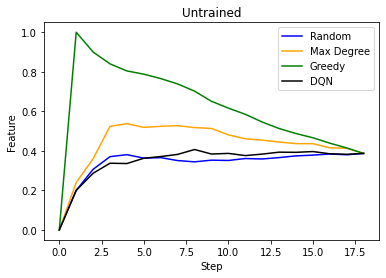

In [99]:
plt.title('Train Networks (Untrained DQN)')
plt.xlabel('Step')
plt.ylabel('Feature')
plt.plot(feature_values_mean_random, label = 'Random', color = 'blue')
plt.plot(feature_values_mean_degree, label = 'Max Degree', color = 'orange')
plt.plot(feature_values_mean_greedy, label = 'Greedy', color = 'green')
plt.plot(feature_values_mean_DQN, label = 'DQN', color = 'black')
plt.legend()

# Train DQN Agent

In [100]:
epsilon = hyperparameters['epsilon_initial'] # exploration rate
epsilon_decay_rate = hyperparameters['epsilon_decay_rate'] 
epsilon_min = hyperparameters['epsilon_min']

discount_factor = hyperparameters['discount_factor']
learning_rate = hyperparameters['learning_rate']

num_steps = 30000 # number of steps in each environment

replay_buffer = ReplayBuffer(hyperparameters['buffer_size'])
train_start = hyperparameters['train_start']
batch_size = hyperparameters['batch_size']
learn_every = hyperparameters['learn_every']

optimizer = torch.optim.Adam([{'params': embedding_module.parameters()}, 
                              {'params': q_net.parameters()}], 
                             lr = learning_rate)
agent = DQNAgent(embedding_module, q_net, 
                 replay_buffer, train_start, batch_size, 
                 learn_every, 
                 optimizer, 
                 epsilon, epsilon_decay_rate, epsilon_min)

In [101]:
def prun_test():

  train_results, val_results = learn_environments(agent, 
                                                  train_environments, 
                                                  val_environments,
                                                  num_steps, 
                                                  discount_factor)

  return train_results, val_results

In [102]:
%prun train_results, val_results = prun_test()

Loss: 0.02598, Val. Score: 7.61529: 100%|██████████| 1000/1000 [01:47<00:00,  9.32Step/s]

In [103]:
# here it would be nice to print train loss, validation loss

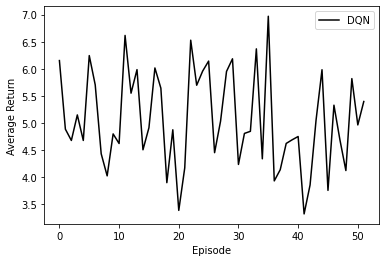

In [104]:
plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.plot(np.mean(np.array(train_results['returns']), axis = 0), 
         label = 'DQN', color = 'black')
plt.legend()

In [105]:
#@title Individual Environment Plots

# plt.xlabel('Episode')
# plt.ylabel('Return')
# for idx, environment_returns in enumerate(returns):
#   plt.plot(environment_returns, label = f'Env: {idx}')
# plt.legend()

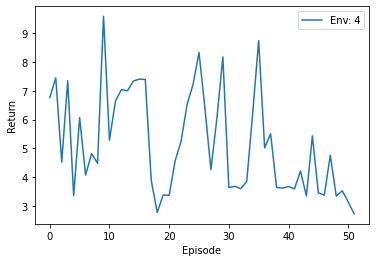

In [106]:
idx = 4
plt.xlabel('Episode')
plt.ylabel('Return')
plt.plot(train_results['returns'][idx], label = f'Env: {idx}')
plt.legend()

In [107]:
get_NX_subgraph.cache_info()

CacheInfo(hits=3548, misses=25260, maxsize=100000, currsize=25260)

In [108]:
get_PyG_subgraph.cache_info()

CacheInfo(hits=263155, misses=52373, maxsize=500000, currsize=52373)

In [109]:
compute_feature_value.cache_info()

CacheInfo(hits=32341, misses=25257, maxsize=100000, currsize=25257)

In [110]:
get_neighbors.cache_info()

CacheInfo(hits=40927, misses=25250, maxsize=100000, currsize=25250)

In [111]:
agent = DQNAgent(embedding_module, q_net, 
                 replay_buffer = None, train_start = None, batch_size = None, learn_every = None, 
                 optimizer = None, 
                 epsilon = 0, epsilon_decay_rate = None, epsilon_min = None)

all_feature_values = simulate(agent, train_environments, num_episodes)
feature_values_mean_DQN = np.mean(np.mean(np.array(all_feature_values), axis = 0), axis = 0)

100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


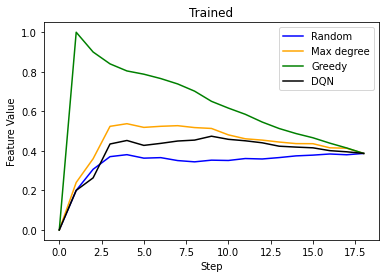

In [112]:
plt.title('Train Performance')
plt.xlabel('Step')
plt.ylabel('Feature Value')
plt.plot(feature_values_mean_random, label = 'Random', color = 'blue')
plt.plot(feature_values_mean_degree, label = 'Max degree', color = 'orange')
plt.plot(feature_values_mean_greedy, label = 'Greedy', color = 'green')
plt.plot(feature_values_mean_DQN, label = 'DQN', color = 'black')
plt.legend()

# Evaluate Test Performance

In [113]:
agent = RandomAgent()
all_feature_values = simulate(agent, test_environments, num_episodes)
feature_values_mean_random = np.mean(np.mean(np.array(all_feature_values), axis = 0), axis = 0)

agent = HighestDegreeAgent()
all_feature_values = simulate(agent, test_environments, num_episodes)
feature_values_mean_degree = np.mean(np.mean(np.array(all_feature_values), axis = 0), axis = 0)

agent = GreedyAgent()
all_feature_values = simulate(agent, test_environments, num_episodes)
feature_values_mean_greedy = np.mean(np.mean(np.array(all_feature_values), axis = 0), axis = 0)

agent = DQNAgent(embedding_module, q_net, 
                 replay_buffer = None, train_start = None, batch_size = None, learn_every = None, 
                 optimizer = None, 
                 epsilon = 0, epsilon_decay_rate = None, epsilon_min = None)
all_feature_values = simulate(agent, test_environments, num_episodes)
feature_values_mean_DQN = np.mean(np.mean(np.array(all_feature_values), axis = 0), axis = 0)

agent = DQNAgent(embedding_module_untrained, q_net_untrained, 
                 replay_buffer = None, train_start = None, batch_size = None, learn_every = None, 
                 optimizer = None, 
                 epsilon = 1, epsilon_decay_rate = None, epsilon_min = None)
all_feature_values = simulate(agent, test_environments, num_episodes)
feature_values_mean_DQN_untrained = np.mean(np.mean(np.array(all_feature_values), axis = 0), axis = 0)

100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


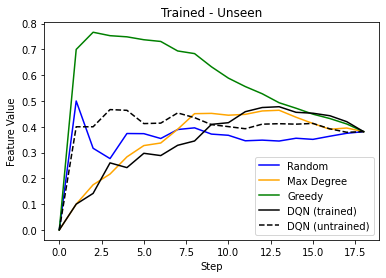

In [114]:
plt.title('Test Performance')
plt.xlabel('Step')
plt.ylabel('Feature Value')
plt.plot(feature_values_mean_random, label = 'Random', color = 'blue')
plt.plot(feature_values_mean_degree, label = 'Max Degree', color = 'orange')
plt.plot(feature_values_mean_greedy, label = 'Greedy', color = 'green')
plt.plot(feature_values_mean_DQN, label = 'DQN (trained)', color = 'black')
plt.plot(feature_values_mean_DQN_untrained, label = 'DQN (untrained)', color = 'black', linestyle = 'dashed')
plt.legend()

In [115]:
#@title Miscellaneous code

# class Batch(NamedTuple):

#   state_embedding: torch.Tensor
#   action: torch.Tensor
#   next_state_embedding: torch.Tensor
#   reward: torch.Tensor
#   discount: torch.Tensor

# class ReplayBuffer():

#   def __init__(self, state_dimensionality, action_dimensionality, buffer_size):

#     self.buffer_size = buffer_size
#     self.ptr = 0
#     self.n_samples = 0
#     self.state_embedding = torch.zeros(buffer_size, state_dimensionality, 
#                                        dtype = torch.float32)
#     self.action = torch.zeros(buffer_size, action_dimensionality, 
#                               dtype = torch.int64)
#     self.next_state_embedding = torch.zeros(buffer_size, state_dimensionality, 
#                                             dtype = torch.float32)
#     self.reward = torch.zeros(buffer_size, 1, 
#                               dtype = torch.float32)
#     self.discount = torch.zeros(buffer_size, 1, 
#                                 dtype = torch.float32)


#   def add(self, state_embedding, action, next_state_embedding, reward, discount):

#     self.state_embedding[self.ptr] = state_embedding
#     self.action[self.ptr] = action
#     self.next_state_embedding[self.ptr] = next_state_embedding
#     self.reward[self.ptr] = reward
#     self.discount[self.ptr] = discount
    
#     if self.n_samples < self.buffer_size:
#       self.n_samples += 1

#     self.ptr = (self.ptr + 1) % self.buffer_size

#   def sample(self, batch_size):

#     idx = np.random.choice(self.n_samples, batch_size)    
#     state_embedding = self.state_embedding[idx]
#     action = self.action[idx]
#     next_state_embedding = self.next_state_embedding[idx]
#     reward = self.reward[idx]
#     discount = self.discount[idx]
    
#     return Batch(state_embedding, action, next_state_embedding, reward, discount)

# class Batch(NamedTuple):

#   state: torch_geometric.data.data.Data
#   action: torch.Tensor
#   next_state: torch_geometric.data.data.Data
#   reward: torch.Tensor
#   discount: torch.Tensor

# class ReplayBuffer():

#   def __init__(self, state_dimensionality, buffer_size):

#     self.buffer_size = buffer_size
#     self.ptr = 0
#     self.n_samples = 0
    
#     self.state = torch.zeros(buffer_size, state_dimensionality, dtype = torch.float32)
#     self.action = torch.zeros(buffer_size, 1, dtype = torch.int64)
#     self.next_state = torch.zeros(buffer_size, state_dimensionality, dtype = torch.float32)
#     self.reward = torch.zeros(buffer_size, 1, dtype = torch.float32)
#     self.discount = torch.zeros(buffer_size, 1, dtype = torch.float32)


#   def add(self, state, action, next_state, reward, discount):

#     self.state[self.ptr] = state
#     self.action[self.ptr] = action
#     self.next_state[self.ptr] = next_state
#     self.reward[self.ptr] = reward
#     self.discount[self.ptr] = discount
    
#     if self.n_samples < self.buffer_size:
#       self.n_samples += 1

#     self.ptr = (self.ptr + 1) % self.buffer_size

#   def sample(self, batch_size):

#     idx = np.random.choice(self.n_samples, batch_size)    
#     state = self.state[idx]
#     action = self.action[idx]
#     next_state = self.next_state[idx]
#     reward = self.reward[idx]
#     discount = self.discount[idx]
    
#     return Batch(state, action, next_state, reward, discount)

# class QNetworkAgent():

#   def __init__(self, environment, embedding_module, q_net, optimizer, 
#                replay_buffer, batch_size, epsilon):
#     super().__init__()

#     self.is_trainable = True # useful to manage control flow during simulations

#     self.environment = environment
#     self.embedding_module = embedding_module
#     self.q_net = q_net
#     self.optimizer = optimizer

#     self.replay_buffer = replay_buffer
#     self.batch_size = batch_size # number of points to sample from the buffer

#     self.epsilon = epsilon

#   def choose_action(self):

#     available_actions = self.environment.get_actions()

#     with torch.no_grad(): # gradients are not needed when selecting actions
#       # Option 1: perform epsilon-greedy exploration
#       if np.random.uniform() < self.epsilon:
#         return random.choice(available_actions)
#       # Option 2: select action greedily based on q-values
#       else:
#         state_embedding = self.embedding_module(self.environment.state_PyG)
#         q_values = self.q_net(state_embedding)
#         valid_q_values = q_values[0][available_actions]
#         action_idx = torch.argmax(valid_q_values).item()
#         return available_actions[action_idx]

#   def train(self, state, action, next_state, reward, discount, step):

#     # with torch.no_grad():
#     #   state_embedding = self.embedding_module(state)
#     #   next_state_embedding = self.embedding_module(next_state)

#     # self.replay_buffer.add(state_embedding, action, 
#     #                        next_state_embedding, reward, discount)

#     self.replay_buffer.add(state, action, next_state, reward, discount)

#     if step < self.batch_size:
#       return # do not train until the buffer has at least one data batch

#     batch = self.replay_buffer.sample(self.batch_size)

#     # (1) Predict a q-value based on state-action pair
#     # state_embedding = self.embedding_module(state)
#     q_values = self.q_net(self.embedding_module(batch.state))
#     q_predicted = q_values.gather(1, batch.action)

#     # (2) Compute target q-value; no gradient is needed for the target
#     with torch.no_grad():
#       # next_q_values = self.q_net(batch.next_state_embedding)
#       next_q_values = self.q_net(self.embedding_module(batch.next_state))
#       q_target = next_q_values.max(dim = 1)[0].view(-1, 1)
#       q_target = batch.reward + batch.discount * q_target

#     # (3) Compute MSE loss between the predicted and target q-values
#     loss = F.mse_loss(q_predicted, q_target).mean()

#     # (4) Backpropagate gradients
#     self.optimizer.zero_grad()
#     loss.backward()
#     self.optimizer.step()

# num_episodes = 500
# discount_factor = 0.25

# all_episode_returns_q_net = learn_environment(environment, agent, 
#                                               num_episodes, discount_factor)

# print(compute_Frobenius_norm(embedding_module), compute_Frobenius_norm(q_net))

# plt.figure()
# plt.xlabel('Episode')
# plt.ylabel('Return')
# plt.plot(all_episode_returns_q_net, label = 'q-net')
# plt.legend()

# states_NX, states_PyG, rewards, feature_values, steps = simulate(environment, agent, 10)
# rewards_mean_QNet = np.mean(np.array(rewards), axis = 0)
# feature_values_mean_QNet = np.mean(np.array(feature_values), axis = 0)

# plt.figure()
# plt.xlabel('Step')
# plt.ylabel('Average Clustering')
# plt.plot(feature_values_mean_random, label = 'random')
# plt.plot(feature_values_mean_degree, label = 'max degree')
# plt.plot(feature_values_mean_greedy, label = 'greedy')
# plt.plot(feature_values_mean_QNet, label = 'q-net')
# plt.legend()

# agent = QNetworkAgent(environment, embedding_module, q_net, optimizer, epsilon)
# all_episode_returns_q_net = learn_environment(environment, agent, 
#                                               500, discount_factor)

# def learn_environment(environment, agent, num_episodes, 
#                       discount_factor = None, verbose = True):
#   """learn_environment() simulates agent-environment interaction for 
#   a number of steps specified by num_steps and trains the agent if it is 
#   capable of being trained. Note that the interaction ends after a finite 
#   number of steps regardless of whether the ongoing episode has terminated."""

#   all_episode_returns = []
#   all_episode_feature_values = []

#   for episode in tqdm(range(num_episodes), disable = not verbose):

#     state_dict, terminal, info = environment.reset()
#     episode_return = 0 # to track cumulative reward (i.e. return) in ongoing episode
#     episode_feature_values = [info['feature_value']]

#     while not terminal:
#       action = agent.choose_action()
#       next_state_dict, reward, terminal, info = environment.step(action)
#       episode_return += reward
#       episode_feature_values.append(info['feature_value'])

#       if agent.is_trainable:
#         discount = discount_factor * (1 - terminal)
#         agent.train(state_dict, action, next_state_dict, reward, discount) 

#       state_dict = next_state_dict
      
#     all_episode_returns.append(episode_return)
#     all_episode_feature_values.append(episode_feature_values)

#   environment.reset()

#   return all_episode_returns, all_episode_feature_values

# def learn_environment(environment, agent, num_steps, 
#                       discount_factor = None, verbose = True):
#   """
#   Simulate agent-environment interaction for a specified number of steps
#   and train the agent if it is capable of being trained. Note that the 
#   interaction ends after the specified number of steps regardless of whether the 
#   ongoing episode has terminated.
#   """

#   all_episode_returns = []
#   all_episode_feature_values = []

#   episode_return = 0
#   episode_feature_values = []
#   state_dict, terminal, info = environment.reset()

#   for step in tqdm(range(num_steps), disable = not verbose):
#     action = agent.choose_action()
#     next_state_dict, reward, terminal, info = environment.step(action)
#     episode_return += reward
#     episode_feature_values.append(info['feature_value'])

#     if agent.is_trainable:
#       discount = discount_factor * (1 - terminal)
#       agent.train(state_dict, action, next_state_dict, reward, discount, info) 

#     if terminal:
#       all_episode_returns.append(episode_return)
#       episode_return = 0
#       all_episode_feature_values.append(episode_feature_values)
#       episode_feature_values = []
#       state_dict, terminal, info = environment.reset()

#     else:
#       state_dict = next_state_dict

#   environment.reset()

#   return all_episode_returns, all_episode_feature_values

# class QNetworkAgent_Vanilla():

#   def __init__(self, environment, 
#                embedding_module, q_net, 
#                optimizer, 
#                epsilon, epsilon_decay_rate, epsilon_min):
#     super().__init__()

#     self.is_trainable = True # useful to manage control flow during simulations

#     self.environment = environment
#     self.embedding_module = embedding_module
#     self.q_net = q_net
#     self.optimizer = optimizer


#     self.epsilon = epsilon # probability with which to select a non-greedy action
#     self.epsilon_decay_rate = epsilon_decay_rate
#     self.epsilon_min = epsilon_min

#   def choose_action(self):

#     available_actions = self.environment.get_actions(self.environment.visited)

#     new_subgraph_list = [] # list to store all possible next states
#     for action in available_actions:
#       visited_nodes_new = deepcopy(self.environment.visited)
#       visited_nodes_new.append(action)
#       new_subgraph = self.environment.graph_PyG.subgraph(torch.tensor(visited_nodes_new))
#       new_subgraph_list.append(new_subgraph)

#     # create a batch to allow for a single forward pass
#     new_subgraph_batch = Batch.from_data_list(new_subgraph_list)

#     with torch.no_grad():
#       q_values = self.q_net(self.embedding_module(new_subgraph_batch.x, 
#                                                   new_subgraph_batch.edge_index, 
#                                                   new_subgraph_batch.batch))
      
#     if torch.rand(1) < self.epsilon: # explore
#       action = np.random.choice(available_actions)
#     else: # exploit
#       action_idx = torch.argmax(q_values).item()
#       action = available_actions[action_idx]

#     return action

#   def train(self, state_dict, action, next_state_dict, reward, discount, info):
    
#     # (1) Build state + action (= next_state) subgraph 
#     visited_nodes_new = deepcopy(state_dict['visited'])
#     visited_nodes_new.append(action)
#     assert visited_nodes_new == next_state_dict['visited'], "train() assertion failed."
#     new_subgraph = self.environment.graph_PyG.subgraph(torch.tensor(visited_nodes_new))
    
#     # (2) Pass next_state subgraph through ANN to get predicted q-value
#     q_prediction = self.q_net(self.embedding_module(new_subgraph.x, 
#                                                    new_subgraph.edge_index))
    
#     # (3) Compute target q-value
#     available_actions = self.environment.get_actions(next_state_dict['visited'])
#     if available_actions: # states that are terminal have no available actions
#       new_subgraphs = []
#       for action in available_actions:
#         visited_nodes_new = deepcopy(next_state_dict['visited'])
#         visited_nodes_new.append(action)
#         new_subgraph = self.environment.graph_PyG.subgraph(torch.tensor(visited_nodes_new))
#         new_subgraphs.append(new_subgraph)

#       batch = Batch.from_data_list(new_subgraphs)
#       with torch.no_grad():
#         q_target = self.q_net(self.embedding_module(batch.x, 
#                                                     batch.edge_index, 
#                                                     batch.batch))
#         q_target = q_target.max().view(-1, 1)
#         q_target = reward + discount * q_target
      
#       # (4) Compute MSE loss between the predicted and target q-values
#       loss = F.mse_loss(q_prediction, q_target)

#       # (5) Backpropagate gradients
#       self.optimizer.zero_grad()
#       loss.backward()
#       self.optimizer.step()

#       # (6) Decrease exploration rate
#       self.epsilon *= self.epsilon_decay_rate
#       self.epsilon = max(self.epsilon, self.epsilon_min)

# class DQNAgent_SingleEnvironment():

#   def __init__(self, environment, 
#                embedding_module, q_net, 
#                replay_buffer, train_start, batch_size, 
#                learn_every,
#                optimizer, 
#                epsilon, epsilon_decay_rate, epsilon_min):
#     super().__init__()

#     self.is_trainable = True # useful to manage control flow during simulations

#     self.environment = environment

#     self.embedding_module = embedding_module
#     self.q_net = q_net

#     self.target_embedding_module = deepcopy(embedding_module)
#     self.target_q_net = deepcopy(q_net)
    
#     # disable gradients for target networks
#     for parameter in self.target_embedding_module.parameters():
#       parameter.requires_grad = False
#     for parameter in self.target_q_net.parameters():
#       parameter.requires_grad = False
    
#     self.replay_buffer = replay_buffer
#     self.train_start = train_start # specify burn-in period
#     self.batch_size = batch_size
#     self.learn_every = learn_every # steps between updates to target nets

#     self.optimizer = optimizer

#     self.epsilon = epsilon # probability with which to select a non-greedy action
#     self.epsilon_decay_rate = epsilon_decay_rate
#     self.epsilon_min = epsilon_min

#     self.step = 0 

#   def choose_action(self):

#     available_actions = self.environment.get_actions(self.environment.visited)

#     new_subgraphs = [] # list to store all possible next states
#     for action in available_actions:
#       visited_nodes_new = deepcopy(self.environment.visited)
#       visited_nodes_new.append(action)
#       new_subgraph = get_PyG_subgraph(self.environment, frozenset(visited_nodes_new))
#       new_subgraphs.append(new_subgraph)

#     # create a batch to allow for a single forward pass
#     batch = Batch.from_data_list(new_subgraphs)
#     # gradients for the target networks are disabled
#     with torch.no_grad(): 
#       q_values = self.target_q_net(self.target_embedding_module(batch.x, 
#                                                                 batch.edge_index, 
#                                                                 batch.batch))

#     if torch.rand(1) < self.epsilon: # explore
#       action = np.random.choice(available_actions)
#     else: # exploit
#       action_idx = torch.argmax(q_values).item()
#       action = available_actions[action_idx]

#     return action

#   def train(self, state_dict, action, next_state_dict, reward, discount, info):

#     self.replay_buffer.add(state_dict, action, 
#                            next_state_dict, 
#                            reward, discount, info)
#     self.step += 1

#     if self.step < self.train_start: # inside the burn-in period
#       return

#     # (1) Get lists of experiences from memory
#     states, actions, next_states, rewards, discounts, info = self.replay_buffer.sample(self.batch_size)
    
#     # (2) Build state + action = new subgraph (technically identical to next state)
#     new_subgraphs = []
#     for idx, state_dict in enumerate(states):
#       visited_nodes_new = deepcopy(state_dict['visited'])
#       visited_nodes_new.append(actions[idx])
#       assert visited_nodes_new == next_states[idx]['visited'], "train() assertion failed."
#       new_subgraph = get_PyG_subgraph(self.environment, frozenset(visited_nodes_new))
#       new_subgraphs.append(new_subgraph)
#     batch = Batch.from_data_list(new_subgraphs)

#     # (3) Pass batch of next_state subgraphs through ANN to get predicted q-values
#     q_predictions = self.q_net(self.embedding_module(batch.x, 
#                                                      batch.edge_index, 
#                                                      batch.batch))

#     # (4) Compute target q-values for batch
#     q_targets = []
#     for idx, next_state_dict in enumerate(next_states):
#       available_actions = self.environment.get_actions(next_state_dict['visited'])
#       if available_actions: # terminal states have no available actions
#         new_subgraphs = [] # each available action results in a new state
#         for action in available_actions:
#           visited_nodes_new = deepcopy(next_state_dict['visited'])
#           visited_nodes_new.append(action)
#           new_subgraph = get_PyG_subgraph(self.environment, frozenset(visited_nodes_new))
#           new_subgraphs.append(new_subgraph)
#         batch = Batch.from_data_list(new_subgraphs)
#         with torch.no_grad(): # technically, no_grad() is unnecessary
#           q_target = self.target_q_net(self.target_embedding_module(batch.x, 
#                                                                     batch.edge_index, 
#                                                                     batch.batch))
#           q_target = q_target.max().view(-1, 1) # get the largest next q-value
#           q_target = rewards[idx] + discounts[idx] * q_target
#           q_targets.append(q_target)
#       else:
#         q_targets.append(rewards[idx])
#     q_targets = torch.Tensor(q_targets).view(-1, 1)
      
#     # (5) Compute MSE loss between predicted and target q-values
#     loss = F.mse_loss(q_predictions, q_targets).mean()

#     # (6) Backpropagate gradients
#     self.optimizer.zero_grad()
#     loss.backward()
#     self.optimizer.step()

#     # (7) Copy parameters from source to target networks
#     if self.step % self.learn_every == 0: 
#       copy_parameters_from_to(self.embedding_module, self.target_embedding_module)
#       copy_parameters_from_to(self.q_net, self.target_q_net)
      
#     # (8) Decrease exploration rate
#     self.epsilon *= self.epsilon_decay_rate
#     self.epsilon = max(self.epsilon, self.epsilon_min)

# run_times_2 = []

# N = 20 # number of nodes
# m = 2 # number of edges from new node (Barabasi-Albert)
# p = 0.4 # probability of edge creation (Erdos-Renyi)

# feature = nx.average_clustering
# # feature = betti_numbers

# for num_environments in range(1, 10):
#   environments = []
  
#   for i in range(num_environments):
#     G = nx.erdos_renyi_graph(n = N, p = p)
#     # G = nx.barabasi_albert_graph(n = N, m = m)
#     G = node_featurizer(G)
#     environment = GraphEnvironment(i, G, feature)
#     environments.append(environment)

#   environments = MultipleEnvironments(environments)

#   embedding_module = GNN(hyperparameters)
#   q_net = QN(hyperparameters)
#   replay_buffer = ReplayBuffer(hyperparameters['buffer_size'])

#   agent = DQNAgent(environments, 
#                    embedding_module, q_net, 
#                    replay_buffer, train_start, batch_size, 
#                    learn_every, 
#                    optimizer, 
#                    epsilon, epsilon_decay_rate, epsilon_min)
  
#   start = time.process_time()
#   returns, _ = learn_environments(environments, agent, 
#                                   num_steps, 
#                                   discount_factor, 
#                                   verbose = True)
#   run_times_2.append(time.process_time() - start)